<h1><center> Drug Reviews - Exploratory Data Analysis </center></h1>

### Abstract:
Every day, people around the world take doctor prescribed medications to help deal with a variety of diagnoses. I have always wondered how a doctor decides what to prescribe. In this project, I will build machine learning models that “play doctor”! Through utilizing text analytics techniques on patient reviews my models will predict a patient condition and the effectiveness of the treatment (rating).

### Introduction:
In this project, I explore a data-set of over 200,000 drug reviews that was the basis for a recent Kaggle competition. The data set was adapted from the Machine Learning Library at UC Irvine where it was generated through web scraping pharmaceutical reviews . It was first published in a study that looked at sentiment analysis of drug experiences across multiple facets. Medication feedback from customers is extremely helpful for drug companies, doctors, and pharmacists alike who are interested in knowing what drugs are effective and what their side-effects can be.

In [2]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


import warnings
warnings.filterwarnings('ignore')

# Regex library to clean data 
import re, string, gc  

# pretty printing for better legibility
import pprint

# Natural Language Tool Kit 
import nltk  
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Vader Sentiment Analysis Tool
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Web Scrapping Clearner
from bs4 import BeautifulSoup

# Progress bar
from tqdm import tqdm, tqdm_notebook
# Instantiate
tqdm.pandas(tqdm_notebook)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_curve,auc, accuracy_score, recall_score
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.svm import SVC
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [4]:
# Load the data
train = pd.read_csv('drugs_train.csv')
test = pd.read_csv('drugs_test.csv')

In [5]:
print(f'Data Frame has: \n{train.shape[0]} rows \n{train.shape[1]} columns')
print(f'Data Frame has: \n{test.shape[0]} rows \n{test.shape[1]} columns')

Data Frame has: 
161297 rows 
7 columns
Data Frame has: 
53766 rows 
7 columns


In [6]:
train.head(5)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [7]:
list(train) == list(test)

True

In [8]:
print(train.nunique())
print('-'*40)
print(test.nunique())

uniqueID       161297
drugName         3436
condition         884
review         112329
rating             10
date             3579
usefulCount       389
dtype: int64
----------------------------------------
uniqueID       53766
drugName        2637
condition        708
review         48280
rating            10
date            3566
usefulCount      325
dtype: int64


In [9]:
train.shape[0]/test.shape[0] # The training set is 3x the test (75% train and 25% test split)

2.999981400885318

In [10]:
train.drop(columns = ['uniqueID'], inplace=True) # All rows have their own unique column. No reason to keep it.
test.drop(columns = ['uniqueID'], inplace=True) # All rows have their own unique column. No reason to keep it.

In [11]:
print(train.isna().sum().sort_values(ascending = False))
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent Missing'])
(missing_data)

condition      899
usefulCount      0
date             0
rating           0
review           0
drugName         0
dtype: int64


,Total,Percent Missing
condition,899,0.557357
usefulCount,0,0.000000
date,0,0.000000
rating,0,0.000000
review,0,0.000000
drugName,0,0.000000


In [13]:
# Only .55% of the data is missing. Given how small the ammount is, I am going to drop it.

print(train.shape)
train = train.dropna(axis=0)
print(train.shape)

(161297, 6)
(160398, 6)


In [14]:
print(test.isnull().sum().sort_values(ascending = False))
total = test.isnull().sum().sort_values(ascending = False)
percent = (test.isnull().sum()/test.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent Missing'])
missing_data

condition      295
usefulCount      0
date             0
rating           0
review           0
drugName         0
dtype: int64


,Total,Percent Missing
condition,295,0.548674
usefulCount,0,0.000000
date,0,0.000000
rating,0,0.000000
review,0,0.000000
drugName,0,0.000000


In [15]:
print(test.shape)
test = test.dropna(axis=0)
print(test.shape)

(53766, 6)
(53471, 6)


In [16]:
train_conditions = train.condition.value_counts().sort_values(ascending=False)
test_conditions = test.condition.value_counts().sort_values(ascending=False)
print(train_conditions[:10])  # Get the top 10 conditions
print('-'*40)
print(test_conditions[:10])

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64
----------------------------------------
Birth Control      9648
Depression         3095
Pain               2100
Anxiety            1908
Acne               1847
Bipolar Disorde    1380
Weight Loss        1248
Insomnia           1231
Obesity            1189
ADHD               1126
Name: condition, dtype: int64


In [17]:
# Bipolar Disorder was spelled wrong...let's fix that.
train['condition'] = train['condition'].str.replace('Disorde', 'Disorder')
test['condition'] = test['condition'].str.replace('Disorde', 'Disorder')

In [18]:
# Double check the columns are equal
test.columns = train.columns

# Concat the dataframe row wise
bigdata = pd.concat([train, test], ignore_index=True)

display(bigdata.head(10))
print(bigdata.shape)

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,Aripiprazole,Bipolar Disorder,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


(213869, 6)


In [19]:
# LETS CONVERT TO DATETIME SO WE CAN SPLIT THE DATE INTO DAY, MONTH, YEAR. PERHAPS THERE IS SOMETHING USEFUL IN
# LOOKING AT WHEN REVIEWS WERE WRITTEN. 

bigdata['date'] = pd.to_datetime(bigdata['date'])
bigdata['day'] = bigdata['date'].dt.day
bigdata['month'] = bigdata['date'].dt.month
bigdata['year'] = bigdata['date'].dt.year

In [20]:
bigdata.nunique()

drugName         3667
condition         916
review         128449
rating             10
date             3579
usefulCount       397
day                31
month              12
year               10
dtype: int64

In [21]:
print(f'Cases of duplicate:' , len(bigdata[bigdata.duplicated(['drugName','review'])]))

Cases of duplicate: 133


In [22]:
bigdata=bigdata.drop_duplicates(['drugName','review'])
bigdata=bigdata.reset_index(drop=True)

In [23]:
bigdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213736 entries, 0 to 213735
Data columns (total 9 columns):
drugName       213736 non-null object
condition      213736 non-null object
review         213736 non-null object
rating         213736 non-null int64
date           213736 non-null datetime64[ns]
usefulCount    213736 non-null int64
day            213736 non-null int64
month          213736 non-null int64
year           213736 non-null int64
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 14.7+ MB


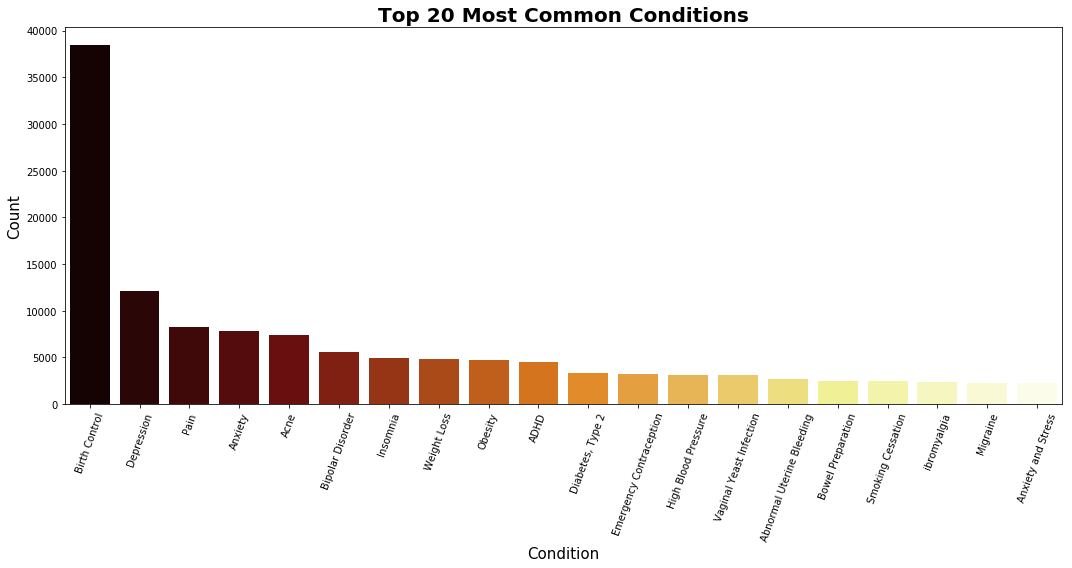

In [24]:
plt.figure(figsize= (15,8))
sns.countplot(x = bigdata['condition'], order = bigdata.condition.value_counts().index[:20], palette='afmhot')
plt.title('Top 20 Most Common Conditions', fontweight= 'bold', size=20 )
plt.xlabel('Condition', size=15)
plt.ylabel('Count', size=15)
plt.xticks(rotation=70)
plt.tight_layout()
plt.show();

In [25]:
# THERE IS A SPELLING MISTAKE WITH FIBROMYALGIA
bigdata['condition'] = bigdata['condition'].str.replace('ibromyalgia', 'Fibromyalgia')

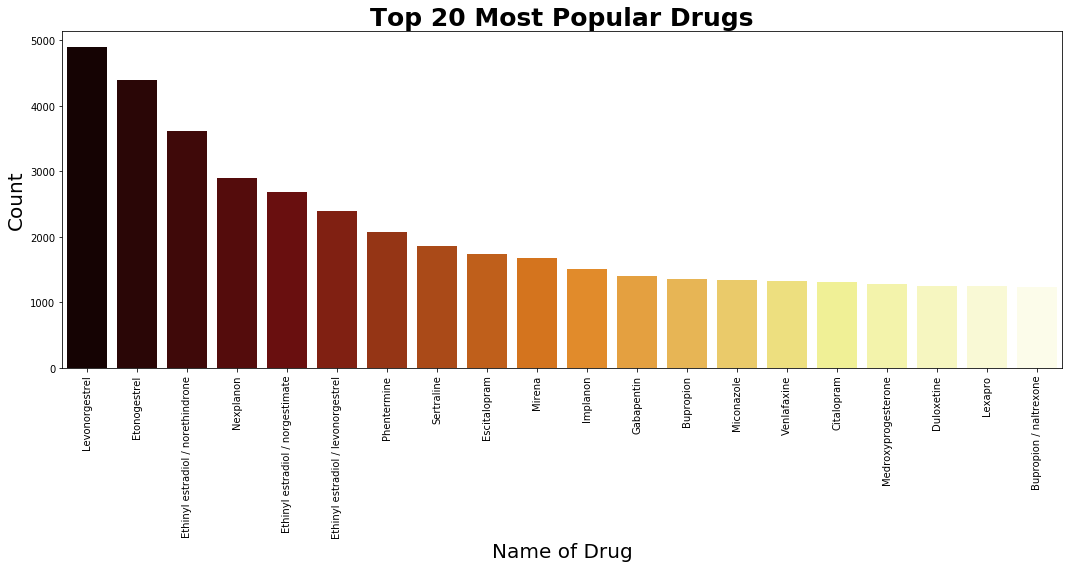

In [26]:
plt.figure(figsize= (15,8))
sns.countplot(x = bigdata['drugName'], order = bigdata.drugName.value_counts().index[:20], palette='afmhot')
plt.title('Top 20 Most Popular Drugs', fontweight= 'bold', size=25 )
plt.xlabel('Name of Drug', size=20)
plt.ylabel('Count', size=20)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

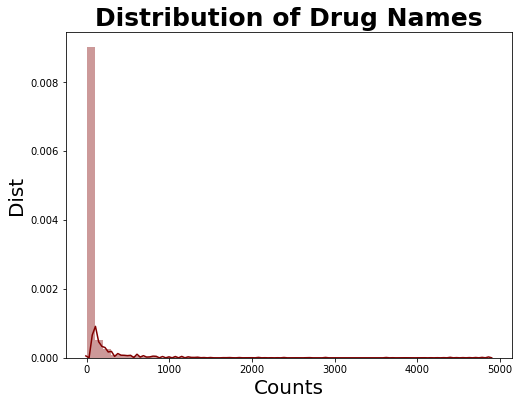

In [27]:
drugs = bigdata['drugName'].value_counts()
plt.figure(figsize=(8, 6))
sns.distplot(drugs, bins=50, kde=True, color='maroon')
plt.xlabel('Counts', fontsize=20)
plt.ylabel('Dist', fontsize=20)
plt.title("Distribution of Drug Names", fontweight= "bold", size=25 )
plt.show();
# There is a significant right skew (positive skew) in the data set. Certain drugs are used a lot more than others.

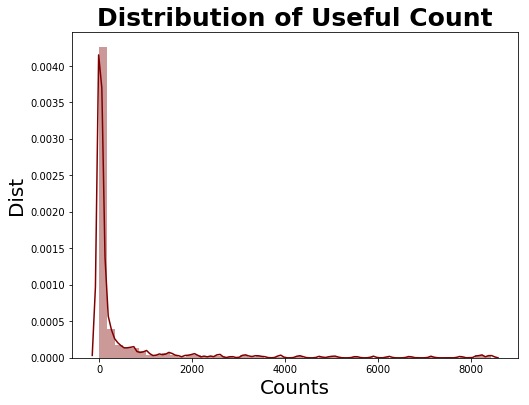

In [28]:
drugs = bigdata['usefulCount'].value_counts()
plt.figure(figsize=(8, 6))
sns.distplot(drugs, bins=50, kde=True, color='maroon')
plt.xlabel('Counts', fontsize=20)
plt.ylabel('Dist', fontsize=20)
plt.title("Distribution of Useful Count", fontweight= "bold", size=25 )
plt.show();

In [29]:
# Note that useful count is for how many people found a review to be useful. The high useful counts are for 
# the most common drugs, conditions.

Text(0.5, 1.0, 'Top 20 : The number of drugs per condition.')

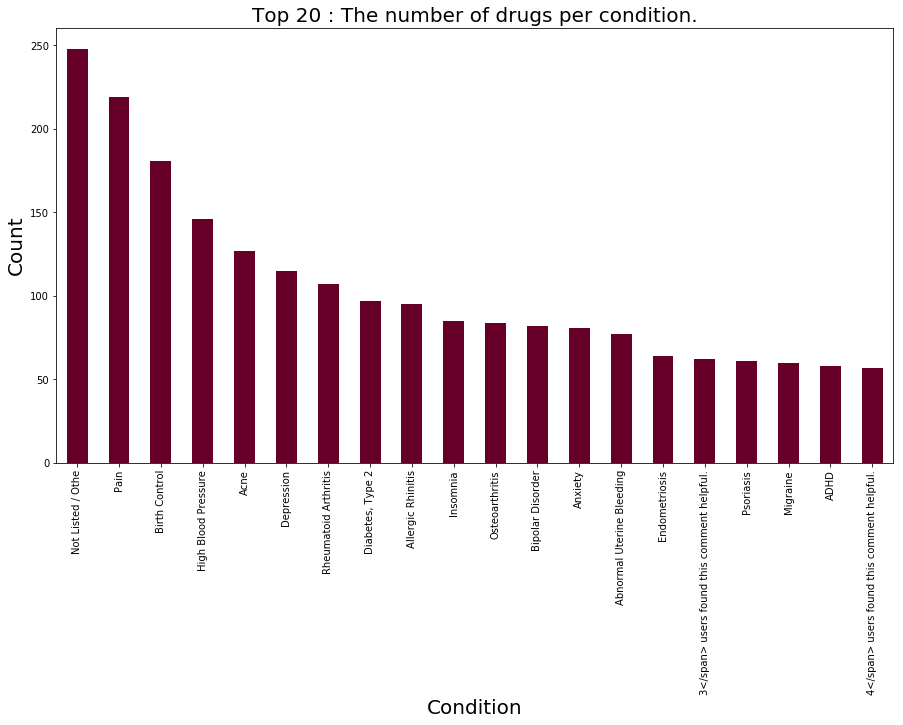

In [30]:
dpc = bigdata.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
dpc[0:20].plot(kind="bar", figsize = (15,8), fontsize = 10,color="#660029")
plt.xlabel("Condition", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Top 20 : The number of drugs per condition.", fontsize = 20)

In [31]:
# Notice above the htlm code 3</span>, 4</span> is showing up in the top 20 conditions. 
# I will address this in later steps.

In [32]:
bigdata['condition'] = bigdata['condition'].str.replace('Cance', 'Cancer')

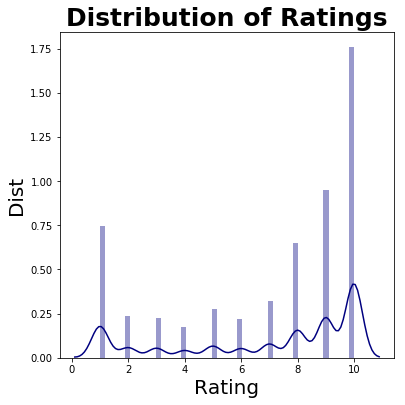

In [33]:
# Notice the bimodal distribution to the ratings. The top ratings are 8-9-10 and then 1. 
plt.figure(figsize=(6,6))
sns.distplot(bigdata['rating'], color='navy')
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Dist', fontsize=20)
plt.title("Distribution of Ratings", fontweight= "bold", size=25 )
plt.show();

In [34]:
# As seen above 3</span> users found this comment helpful is also a condition. This is a top 20 condition!
# The conditions above show "3</span> users found this comment helpful" appears as a condition. I need to clean this up.
len(bigdata[bigdata['condition'].str.contains("</span>")])

1171

In [35]:
all_list = set(bigdata.index)
span_list = []
for i,j in enumerate(bigdata['condition']):
    if '</span>' in j:
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
bigdata = bigdata.iloc[list(new_idx)].reset_index()
del bigdata['index']

print(len(bigdata[bigdata['condition'].str.contains("</span>")]))

0


(-0.5, 399.5, 199.5, -0.5)

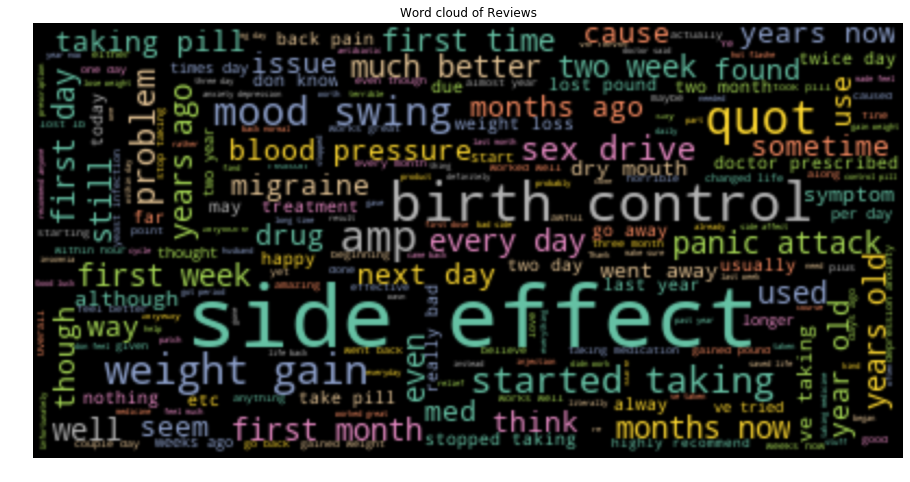

In [36]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize= (16,8))
plt.title('Word cloud of Reviews')
wc = WordCloud(max_words=1000 ,max_font_size=40, background_color='black', stopwords = STOPWORDS, colormap='Set2')
wc.generate(' '.join(bigdata['review']))
plt.imshow(wc,interpolation="gaussian")
plt.axis('off')

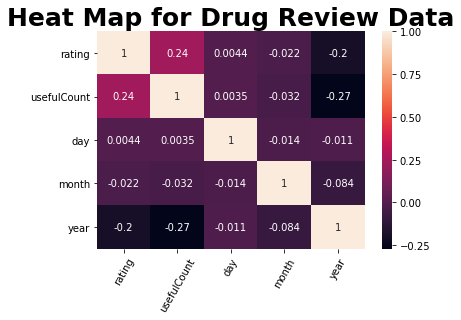

In [37]:
corr = bigdata.corr()
sns.heatmap(corr, annot = True)
plt.xticks(rotation = 60)
plt.title("Heat Map for Drug Review Data",  fontweight="bold", size=25)
plt.show() 

In [38]:
# Interesting that year has a correlation coefficient of -.2. 

Text(0.5, 1.0, 'Mean rating in year')

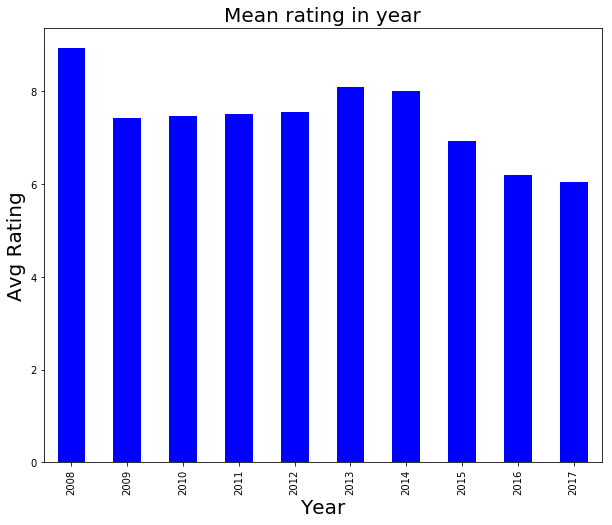

In [39]:
rating = bigdata.groupby('year')['rating'].mean()
rating.plot(kind="bar", figsize = (10,8), fontsize = 10,color="blue")
plt.xlabel("Year", fontsize = 20)
plt.ylabel("Avg Rating", fontsize = 20)
plt.title("Mean rating in year", fontsize = 20)

In [40]:
useful = bigdata.sort_values(by='usefulCount', ascending=False)
useful.reset_index(drop=True)

,drugName,condition,review,rating,date,usefulCount,day,month,year
0,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,2008-07-31,1291,31,7,2008
1,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10,2008-07-31,1291,31,7,2008
2,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009
3,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009
4,Sertraline,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,2008-08-05,949,5,8,2008
5,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,2008-08-05,949,5,8,2008
6,Phentermine,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008
7,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008
8,Citalopram,Depression,"""I responded after one week. The side effects ...",8,2008-03-25,771,25,3,2008
9,Celexa,Depression,"""I responded after one week. The side effects ...",8,2008-03-25,771,25,3,2008


In [41]:
# Look at the top 5 reviews by useful count
for x in useful.review.iloc[:5]:
    print(x, '\n')
# The reviews match for 1 and 2. As well as 3 and 4. It appears however that they are for two different drugs but the same review!
# Upon further research however, I learned that Zoloft is a brand name and Sertaline is the generic drug. While a duplicate rows, 
# wouldn't catch this, having some domain knowledge is really helpful. This is the same with Mirena and Levonrgestrel.
# What should we do here?

"I remember reading people&#039;s opinions, online, of the drug before I took it and it scared me away from it. Then I finally decided to give it a try and it has been the best choice I have made. I have been on it for over 4 months and I feel great. I&#039;m on 100mg and I don&#039;t have any side effects. When I first started I did notice that my hands would tremble but then it subsided. So honestly, don&#039;t listen to all the negativity because what doesn&#039;t work for some works amazing for others. So go based on youself and not everyone else. It may be a blessing in diguise. The pill is not meant to make you be all happy go lucky and see &quot;butterflies and roses&quot;, its meant to help put the chemicals in your mind in balance so you can just be who you are and not overly depressed. I still get sad some times, but that is normal, that is life, and it&#039;s up to people to take control to make a change. I did so by getting on this pill." 

"I remember reading people&#039;s

In [42]:
print(bigdata.shape)
print(f'Cases of duplicate:' , bigdata[bigdata.duplicated(subset=['condition', 'review', 'rating', 'date', 'usefulCount'], keep='first')].shape[0])

(212565, 9)
Cases of duplicate: 84638


In [43]:
print(f' The percentage of our rows that are duplicates:', (84638/212565*100))

 The percentage of our rows that are duplicates: 39.81746759814645


#### I am going to start off by keeping the first instance of these duplicates, and dropping the rest. While we are dropping 39.8% of our data set, there is no reason to keep duplicates.

In [45]:
bigdata = bigdata.drop_duplicates(subset=['condition', 'review', 'rating', 'date', 'usefulCount'], keep='first')
len(bigdata)

127927

In [46]:
bigdata=bigdata.reset_index(drop=True)
bigdata.head(10)

,drugName,condition,review,rating,date,usefulCount,day,month,year
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,20,5,2012
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,27,4,2010
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,14,12,2009
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,3,11,2015
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,27,11,2016
5,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,2015-11-28,43,28,11,2015
6,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,2017-03-07,5,7,3,2017
7,Aripiprazole,Bipolar Disorder,"""Abilify changed my life. There is hope. I was...",10,2015-03-14,32,14,3,2015
8,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,2016-08-09,11,9,8,2016
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,2016-12-08,1,8,12,2016


Text(0, 0.5, 'Distribution')

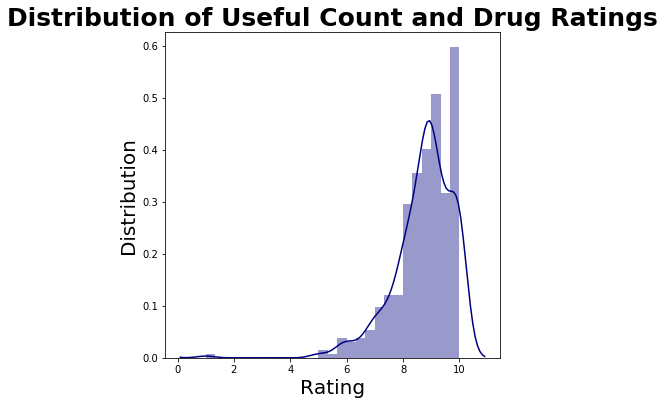

In [47]:
uc_rating_avgs = (bigdata['rating'].groupby(bigdata['usefulCount']).mean())
plt.figure(figsize=(6,6))
sns.distplot(uc_rating_avgs, color='navy')
plt.title('Distribution of Useful Count and Drug Ratings', fontweight= "bold", size=25)
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Distribution', fontsize=20)

In [48]:
# Reviewers find higher ratings to be more useful than lower ratings! Does this show an inherent bias?
# The distplot above shows us that we have very similar distributions of the ratings per drug name.

In [49]:
bigdata.nunique()

drugName         3169
condition         836
review         127285
rating             10
date             3579
usefulCount       397
day                31
month              12
year               10
dtype: int64

In [50]:
# We have 836 unique conditions and 3169 unique drug names. 

In [51]:
# What are the most popular pairings of drugs and conditions.
pairings = bigdata.groupby(['condition','drugName']).size().sort_values(ascending=False)
pairings[0:20]

condition                drugName                          
Birth Control            Etonogestrel                          2219
                         Ethinyl estradiol / norethindrone     1494
                         Nexplanon                             1436
Weight Loss              Phentermine                           1429
Birth Control            Levonorgestrel                        1423
Vaginal Yeast Infection  Miconazole                            1162
Birth Control            Ethinyl estradiol / levonorgestrel    1113
                         Ethinyl estradiol / norgestimate      1106
Vaginal Yeast Infection  Tioconazole                            977
Emergency Contraception  Levonorgestrel                         881
Birth Control            Implanon                               738
                         Mirena                                 664
Smoking Cessation        Varenicline                            632
Birth Control            Skyla                          

In [53]:
bigdata['pop_w_cond']= bigdata.condition.map(bigdata.groupby(['condition']).size())
bigdata['total_users'] = bigdata.drugName.map(bigdata.groupby(['drugName']).size())

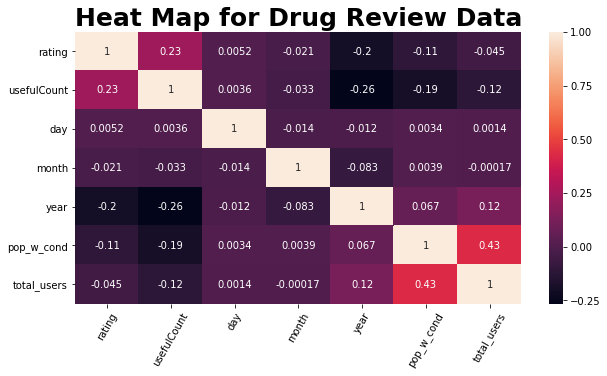

In [55]:
corr = bigdata.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot = True)
plt.xticks(rotation = 60)
plt.title("Heat Map for Drug Review Data",  fontweight="bold", size=25)
plt.show() 

In [56]:
bigdata.to_csv("bigdata_eda.csv")